In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from decipher import PROJECT_BASE
from decipher.datasets.decipher_data import Decipher
from decipher.datasets.depmap import DepMap
from scipy.cluster.hierarchy import (
    dendrogram,
    leaves_list,
    linkage,
    optimal_leaf_ordering,
)
from scipy.stats import mannwhitneyu
import seaborn as sns

## PARP7 interaction heatmap

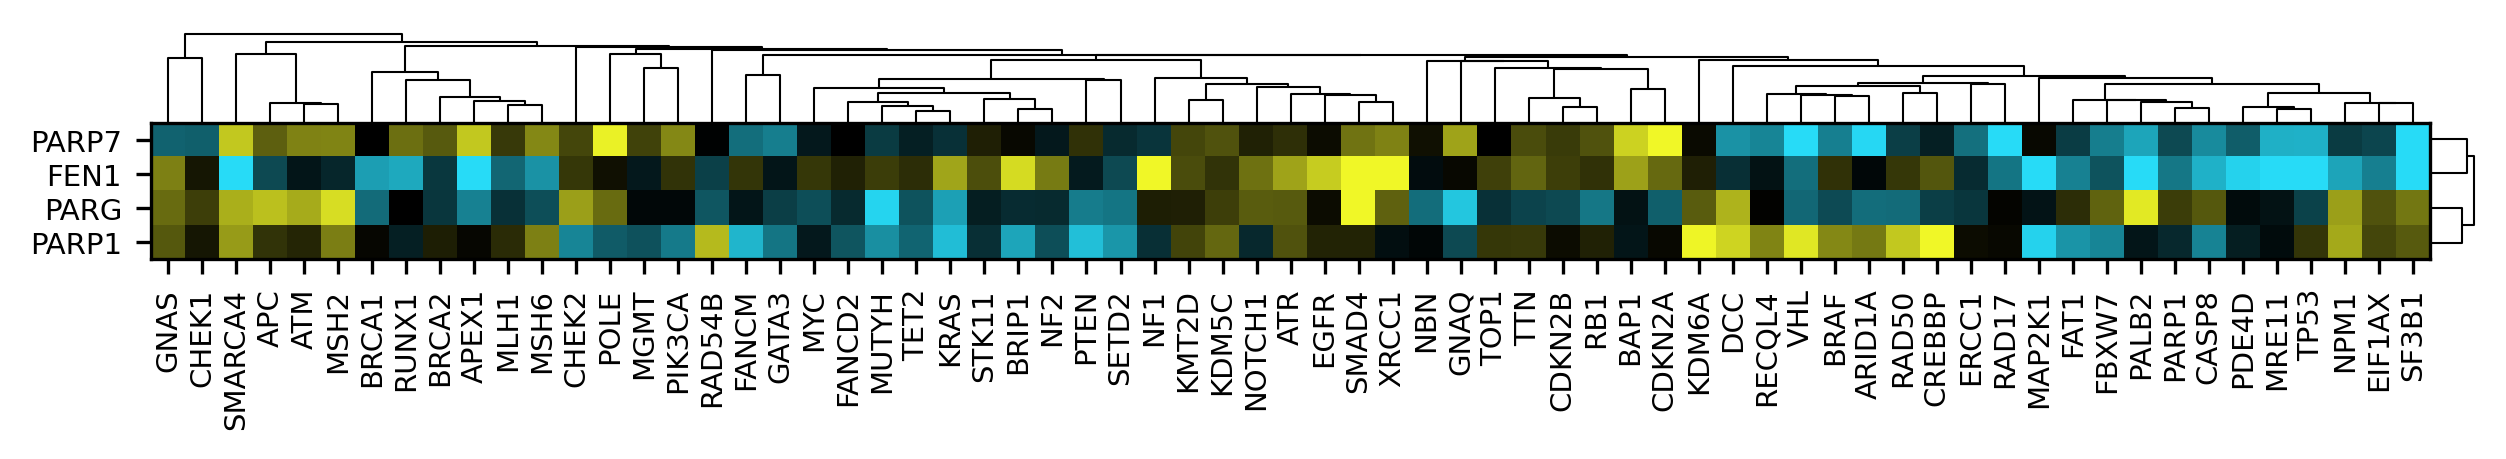

In [3]:
def plot_parp_heatmap():
    decipher = Decipher()
    data = get_parp_interactions(decipher)

    def switch_parp7_parg(data):
        """Switching the first two rows. They are in the same dendrogram."""
        data = data.iloc[[1, 0, 2, 3]]
        index = list(data.index)
        data.index = ["PARP7"] + index[1:]

        return data

    fig, _ = plot_heatmap(data, swap_func=switch_parp7_parg)
    return fig


def get_synthetic_essential_cmap(vmin=-2, vmax=2):
    norm = mpl.colors.Normalize(vmin, vmax)
    colors = [[norm(vmin), "#27dbf7"], [norm(0), "#000000"], [norm(vmax), "#f0f727"]]
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)

    return cmap, norm


def cluster_order(data, **linkage_kwargs):
    Z = linkage(data, **linkage_kwargs)
    Z_ordered = optimal_leaf_ordering(Z, data)
    row_index = leaves_list(Z_ordered)

    Z = linkage(data.T, **linkage_kwargs)
    Z_ordered = optimal_leaf_ordering(Z, data.T)
    col_index = leaves_list(Z_ordered)

    return row_index, col_index


def get_parp_interactions(decipher):
    genes = ["PARG", "PARP1", "FEN1", "TIPARP"]

    data = [decipher.scores.xs(gene)["pan-cancer"] for gene in genes]
    data = pd.concat(data, axis=1).T
    data.index = genes

    data = data[data.columns.difference(["AAVS", "nontargeting"])]

    return data


def plot_heatmap(data, swap_func=None):
    sl_cmap, sl_norm = get_synthetic_essential_cmap()

    gridspec_kw = dict(
        height_ratios=(0.4, 0.6), width_ratios=(0.98, 0.02), hspace=0, wspace=0
    )
    dendrogram_kw = dict(above_threshold_color="black", color_threshold=0)
    rc_context_kw = {"lines.linewidth": 0.5}

    fig, axes = plt.subplots(2, 2, dpi=300, figsize=(10, 1.0), gridspec_kw=gridspec_kw)

    ax = axes[0, 0]
    Z1 = linkage(data.T, metric="cosine")
    # Z1 = optimal_leaf_ordering(Z1, data.T)
    with plt.rc_context(rc_context_kw):
        dn1 = dendrogram(Z1, ax=ax, **dendrogram_kw)
    col_index = dn1["leaves"]
    ax.axis("off")

    ax = axes[1, 1]
    Z2 = linkage(data, metric="cosine")
    # Z2 = optimal_leaf_ordering(Z2, data)
    with plt.rc_context(rc_context_kw):
        dn2 = dendrogram(Z2, ax=ax, orientation="right", **dendrogram_kw)
    row_index = dn2["leaves"]
    ax.axis("off")

    ax = axes[1, 0]
    data = data.iloc[row_index, col_index]

    if swap_func is not None:
        data = swap_func(data)

    ax.imshow(data, cmap=sl_cmap, norm=sl_norm)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))

    ax.set_xticklabels(data.columns[col_index], rotation=90, fontsize=7)
    ax.set_yticklabels(data.index[row_index], fontsize=7)

    axes[0, 1].axis("off")

    return fig, axes

fig = plot_parp_heatmap()

In [5]:
cluster = [
    "NBN",
    "CDKN2A",
    "DCC",
    "KDM6A",
    "MSH2",
    "RB1",
    "XRCC1",
    "KDM5C",
    "TP53",
    "RAD17",
    "CHEK2",
    "PDE4D",
]

In [10]:
depmap = DepMap().load_all()

In [27]:
kdm5c_mut, kdm5c_wt = depmap.separate_cell_lines(
    ["KDM5C"], alteration_data_name="robust_copy_number"
)

/tmp/ipykernel_11148/1763557996.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_11148/1763557996.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")


Text(0, 0.5, 'Fitness effect of\nPARP7 CRISPR knockout')

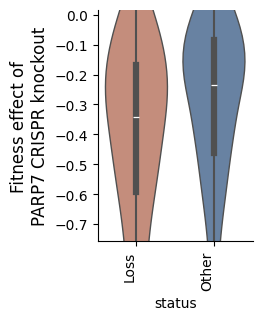

In [29]:
kdm5c_status = pd.concat(
    [
        pd.DataFrame([depmap.query_gene_effect("TIPARP", kdm5c_mut)])
        .T.assign(status="Loss")
        .reset_index(),
        pd.DataFrame([depmap.query_gene_effect("TIPARP", kdm5c_wt)])
        .T.assign(status="Other")
        .reset_index(),
    ],
    axis=0,
)

fig, ax = plt.subplots(figsize=(2, 3))

sns.violinplot(
    kdm5c_status,
    x="status",
    y="TIPARP",
    ax=ax,
    linewidth=1,
    palette={"Loss": "#d08770", "Other": "#5e81ac"},
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.tick_params(labelsize=10)

sns.despine()
# ax.set_yticks([-1, -0.5, 0, 0.5])
# ax.set_xlim([-0.6, 1.6])

sns.despine()
ylim = [
    np.percentile(kdm5c_status["TIPARP"].values, 10),
    np.percentile(kdm5c_status["TIPARP"].values, 90),
]
ax.set_ylim(ylim)
# print(df["status"].value_counts())

ax.set_ylabel("Fitness effect of\nPARP7 CRISPR knockout", fontsize=12)

WT: (n=349) WT: (n=1475)
MannwhitneyuResult(statistic=223178.0, pvalue=5.221369274530453e-06)


/tmp/ipykernel_11148/2063426164.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_11148/2063426164.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")


Text(0, 0.5, 'Fitness effect of\nPARP7 CRISPR knockout')

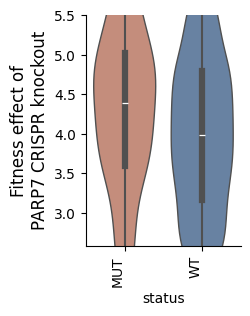

In [26]:

kdm5c_status_exp = pd.concat(
    [
        pd.DataFrame(
            [
                depmap.expression.loc[
                    depmap.expression.index.intersection(kdm5c_mut), "TIPARP"
                ]
            ]
        )
        .T.assign(status="MUT")
        .reset_index(),
        pd.DataFrame(
            [
                depmap.expression.loc[
                    depmap.expression.index.intersection(kdm5c_wt), "TIPARP"
                ]
            ]
        )
        .T.assign(status="WT")
        .reset_index(),
    ],
    axis=0,
)
print(f"WT: (n={len(kdm5c_mut)})", f"WT: (n={len(kdm5c_wt)})")
print(
    mannwhitneyu(*[df["TIPARP"].values for _, df in kdm5c_status_exp.groupby("status")])
)


fig, ax = plt.subplots(figsize=(2, 3))

sns.violinplot(
    kdm5c_status_exp,
    x="status",
    y="TIPARP",
    ax=ax,
    linewidth=1,
    palette={"MUT": "#d08770", "WT": "#5e81ac"},
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.tick_params(labelsize=10)

sns.despine()
# ax.set_yticks([-1, -0.5, 0, 0.5])
# ax.set_xlim([-0.6, 1.6])

sns.despine()
ylim = [
    np.percentile(kdm5c_status_exp["TIPARP"].values, 10),
    np.percentile(kdm5c_status_exp["TIPARP"].values, 90),
]
ax.set_ylim(ylim)
# print(df["status"].value_counts())

ax.set_ylabel("Fitness effect of\nPARP7 CRISPR knockout", fontsize=12)

NBN mut: (n=188) WT: (n=1636)
CDKN2A mut: (n=342) WT: (n=1482)
DCC mut: (n=0) WT: (n=1824)
KDM6A mut: (n=352) WT: (n=1472)
MSH2 mut: (n=186) WT: (n=1638)
RB1 mut: (n=303) WT: (n=1521)
XRCC1 mut: (n=231) WT: (n=1593)
KDM5C mut: (n=349) WT: (n=1475)
TP53 mut: (n=264) WT: (n=1560)
RAD17 mut: (n=244) WT: (n=1580)
CHEK2 mut: (n=291) WT: (n=1533)
PDE4D mut: (n=203) WT: (n=1621)


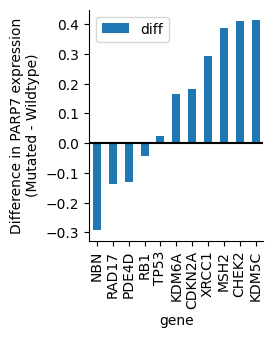

In [15]:
df = []
for gene in cluster:
    mut, wt = depmap.separate_cell_lines(
        [gene], alteration_data_name="robust_copy_number"
    )

    exp = pd.concat(
        [
            pd.DataFrame(
                [
                    depmap.expression.loc[
                        depmap.expression.index.intersection(mut), "TIPARP"
                    ]
                ]
            )
            .T.assign(status="MUT")
            .reset_index(),
            pd.DataFrame(
                [
                    depmap.expression.loc[
                        depmap.expression.index.intersection(wt), "TIPARP"
                    ]
                ]
            )
            .T.assign(status="WT")
            .reset_index(),
        ],
        axis=0,
    )
    print(gene, f"mut: (n={len(mut)})", f"WT: (n={len(wt)})")
    try:
        out = mannwhitneyu(*[df["TIPARP"].values for _, df in exp.groupby("status")])
        diff = exp.drop(columns=["index"]).groupby("status").median()["TIPARP"]
        diff = diff["MUT"] - diff["WT"]
    except KeyError:
        continue

    df.append([gene, diff, out.pvalue])

df1 = pd.DataFrame(df, columns=["gene", "diff", "pvalue"])

fig, ax = plt.subplots(figsize=(2.25, 3))
df1.sort_values(by="diff").plot(kind="bar", x="gene", y="diff", ax=ax)
ax.axhline(0, color="black")
ax.set_ylabel("Difference in PARP7 expression\n(Mutated - Wildtype)")

sns.despine()

Text(0, 0.5, 'Difference in PARP7 KO\n(Mutated - Wildtype)')

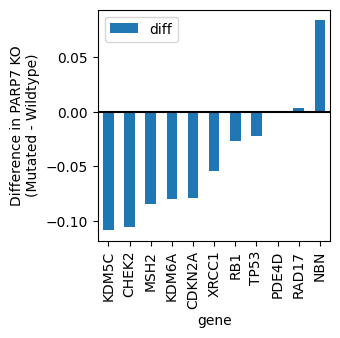

In [17]:
df = []
for gene in cluster:
    mut, wt = depmap.separate_cell_lines(
        [gene], alteration_data_name="robust_copy_number"
    )

    ko = pd.concat(
        [
            pd.DataFrame([depmap.query_gene_effect("TIPARP", mut)])
            .T.assign(status="MUT")
            .reset_index(),
            pd.DataFrame([depmap.query_gene_effect("TIPARP", wt)])
            .T.assign(status="WT")
            .reset_index(),
        ],
        axis=0,
    )

    try:
        out = mannwhitneyu(*[df["TIPARP"].values for _, df in ko.groupby("status")])
        diff = ko.drop(columns=["index"]).groupby("status").median()["TIPARP"]
        diff = diff["MUT"] - diff["WT"]
    except KeyError:
        continue

    df.append([gene, diff, out.pvalue])

df2 = pd.DataFrame(df, columns=["gene", "diff", "pvalue"])

fig, ax = plt.subplots(figsize=(3, 3))
df2.sort_values(by="diff").plot(kind="bar", x="gene", y="diff", ax=ax)
ax.axhline(0, color="black")
ax.set_ylabel("Difference in PARP7 KO\n(Mutated - Wildtype)")

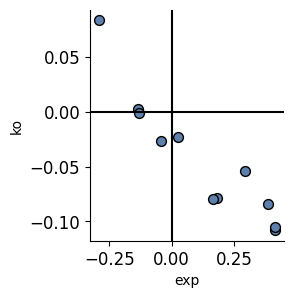

In [18]:
df = pd.concat([df1.set_index("gene")["diff"], df2.set_index("gene")["diff"]], axis=1)
df.columns = ["exp", "ko"]

fig, ax = plt.subplots(figsize=(2.5, 3))
df.plot(kind="scatter", x="exp", y="ko", ax=ax, s=50, c="#5E81AC", edgecolor="black")
ax.axhline(0, color="black")
ax.axvline(0, color="black")

sns.despine()
ax.tick_params(labelsize=12)